In [1]:
!pip install torch torchvision torch-geometric scikit-image networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:00



=== MNIST ===


/tmp/ipython-input-3253342386.py:266: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_g = DataLoader(graph_sets[gtype], bs, shuffle=True)
/tmp/ipython-input-3253342386.py:267: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_g  = DataLoader(test_sets[gtype], bs)


CNN  0.8K  27.33%


GCN-Patch  1.4K  22.58%


GAT-Patch  1.6K  26.03%


GCN-Grid  1.4K  23.54%


GAT-Grid  1.6K  26.79%


GCN-Superpixel  1.4K  22.66%


GAT-Superpixel  1.6K  28.08%

=== EMNIST ===


100%|██████████| 562M/562M [00:07<00:00, 78.8MB/s]


CNN  1.1K  4.99%


GCN-Patch  2.7K  5.65%


GAT-Patch  2.8K  5.99%


GCN-Grid  2.7K  5.28%


GAT-Grid  2.8K  6.26%


GCN-Superpixel  2.7K  5.04%


GAT-Superpixel  2.8K  6.60%


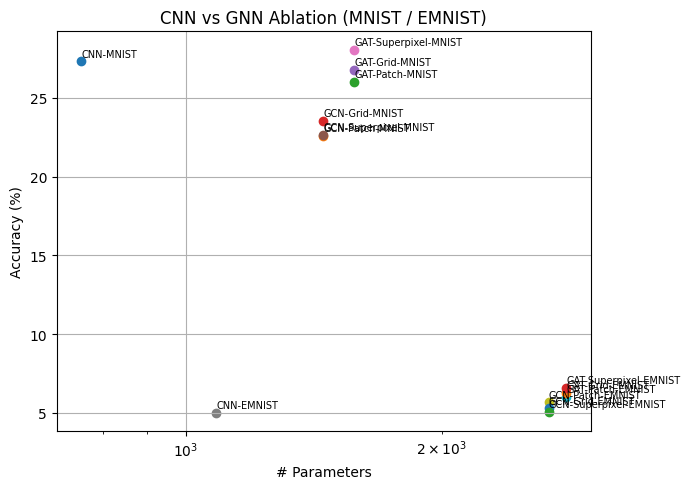

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

from skimage.segmentation import slic
from skimage import graph

from tqdm import tqdm

# =====================================================
# Utils
# =====================================================
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def format_params(n):
    return f"{n/1e3:.1f}K"

# =====================================================
# CNN
# =====================================================
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.c1 = nn.Conv2d(1, 8, 3, padding=1)
        self.c2 = nn.Conv2d(8, 8, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(8, num_classes)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = self.pool(x).flatten(1)
        return self.fc(x)

# =====================================================
# Patch Graph Dataset
# =====================================================
class PatchGraphDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, patch=4):
        self.dataset = dataset
        self.patch = patch

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = img.squeeze()

        P = self.patch
        nodes, pos = [], []

        for i in range(0, 28, P):
            for j in range(0, 28, P):
                patch = img[i:i+P, j:j+P]
                nodes.append(patch.mean())
                pos.append((i // P, j // P))

        x = torch.tensor(nodes, dtype=torch.float).unsqueeze(1)

        edges = []
        W = 28 // P
        for i, (r, c) in enumerate(pos):
            for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < W and 0 <= nc < W:
                    edges.append([i, nr * W + nc])

        edge_index = torch.tensor(edges, dtype=torch.long).t()
        return Data(x=x, edge_index=edge_index, y=torch.tensor(label))

# =====================================================
# Grid Graph Dataset (Pixel)
# =====================================================
class GridGraphDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = img.squeeze()
        H, W = img.shape

        x = img.view(-1, 1)

        edges = []
        for r in range(H):
            for c in range(W):
                i = r * W + c
                for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
                    nr, nc = r + dr, c + dc
                    if 0 <= nr < H and 0 <= nc < W:
                        edges.append([i, nr * W + nc])

        edge_index = torch.tensor(edges, dtype=torch.long).t()
        return Data(x=x, edge_index=edge_index, y=torch.tensor(label))

# =====================================================
# Superpixel Graph Dataset (SLIC)
# =====================================================
class SuperpixelGraphDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, n_segments=50):
        self.dataset = dataset
        self.n_segments = n_segments

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = img.squeeze().numpy()

        segments = slic(
            img,
            n_segments=self.n_segments,
            compactness=10,
            start_label=0,
            channel_axis=None   # IMPORTANT
        )

        rag = graph.rag_mean_color(img, segments)

        x = []
        for node in rag.nodes:
            mask = segments == node
            x.append(img[mask].mean())

        edges = []
        for u, v in rag.edges:
            edges.append([u, v])
            edges.append([v, u])

        return Data(
            x=torch.tensor(x, dtype=torch.float).unsqueeze(1),
            edge_index=torch.tensor(edges, dtype=torch.long).t(),
            y=torch.tensor(label)
        )

# =====================================================
# GCN / GAT
# =====================================================
class SmallGCN(nn.Module):
    def __init__(self, in_dim, hidden, num_classes):
        super().__init__()
        self.c1 = GCNConv(in_dim, hidden)
        self.c2 = GCNConv(hidden, hidden)
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, data):
        x = F.relu(self.c1(data.x, data.edge_index))
        x = F.relu(self.c2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)

class SmallGAT(nn.Module):
    def __init__(self, in_dim, hidden, num_classes, heads=2):
        super().__init__()
        self.c1 = GATConv(in_dim, hidden // heads, heads=heads)
        self.c2 = GATConv(hidden, hidden // heads, heads=heads)
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, data):
        x = F.relu(self.c1(data.x, data.edge_index))
        x = F.relu(self.c2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)

# =====================================================
# Train / Eval
# =====================================================
def run_epoch(model, loader, opt, crit, device, train=True, desc=""):
    model.train() if train else model.eval()
    correct = total = 0

    with torch.set_grad_enabled(train):
        for batch in tqdm(loader, desc=desc, leave=False):
            if isinstance(batch, Data):
                batch = batch.to(device)
                out = model(batch)
                y = batch.y
            else:
                x, y = batch[0].to(device), batch[1].to(device)
                out = model(x)

            loss = crit(out, y)

            if train:
                opt.zero_grad()
                loss.backward()
                opt.step()

            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return 100 * correct / total

# =====================================================
# MAIN
# =====================================================
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    results = []

    datasets = {
        "MNIST": torchvision.datasets.MNIST,
        "EMNIST": lambda root, train, download, transform:
            torchvision.datasets.EMNIST(
                root=root, split="balanced",
                train=train, download=download,
                transform=transform
            )
    }

    EPOCHS = 1

    for name, DS in datasets.items():
        print(f"\n=== {name} ===")

        train_ds = DS("./data", train=True, download=True, transform=T.ToTensor())
        test_ds  = DS("./data", train=False, download=True, transform=T.ToTensor())

        num_classes = len(train_ds.classes)
        crit = nn.CrossEntropyLoss()

        # CNN
        cnn = SmallCNN(num_classes).to(device)
        opt = torch.optim.Adam(cnn.parameters(), 1e-3)
        train_dl = torch.utils.data.DataLoader(train_ds, 128, shuffle=True)
        test_dl  = torch.utils.data.DataLoader(test_ds, 128)

        best = 0
        for ep in range(EPOCHS):
            run_epoch(cnn, train_dl, opt, crit, device, True,
                      desc=f"CNN {name} Epoch {ep+1}/{EPOCHS}")
            best = max(best, run_epoch(cnn, test_dl, opt, crit, device, False,
                                       desc="Eval"))

        results.append(("CNN", name, count_params(cnn), best))
        print(f"CNN  {format_params(count_params(cnn))}  {best:.2f}%")

        # GNN Ablations
        graph_sets = {
            "Patch": PatchGraphDataset(train_ds, 4),
            "Grid": GridGraphDataset(train_ds),
            "Superpixel": SuperpixelGraphDataset(train_ds, 50)
        }
        test_sets = {
            "Patch": PatchGraphDataset(test_ds, 4),
            "Grid": GridGraphDataset(test_ds),
            "Superpixel": SuperpixelGraphDataset(test_ds, 50)
        }

        for gtype in graph_sets:
            bs = 16 if gtype == "Grid" else 64
            train_g = DataLoader(graph_sets[gtype], bs, shuffle=True)
            test_g  = DataLoader(test_sets[gtype], bs)

            for Model, tag in [(SmallGCN, "GCN"), (SmallGAT, "GAT")]:
                model = Model(1, 32, num_classes).to(device)
                opt = torch.optim.Adam(model.parameters(), 1e-3)

                best = 0
                for ep in range(EPOCHS):
                    run_epoch(model, train_g, opt, crit, device, True,
                              desc=f"{tag}-{gtype} {name} Epoch {ep+1}/{EPOCHS}")
                    best = max(best, run_epoch(model, test_g, opt, crit, device, False,
                                               desc="Eval"))

                name_tag = f"{tag}-{gtype}"
                results.append((name_tag, name, count_params(model), best))
                print(f"{name_tag}  {format_params(count_params(model))}  {best:.2f}%")

    # Plot
    plt.figure(figsize=(7,5))
    for m, ds, p, acc in results:
        plt.scatter(p, acc)
        plt.text(p, acc+0.3, f"{m}-{ds}", fontsize=7)

    plt.xscale("log")
    plt.xlabel("# Parameters")
    plt.ylabel("Accuracy (%)")
    plt.title("CNN vs GNN Ablation (MNIST / EMNIST)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.5MB/s]


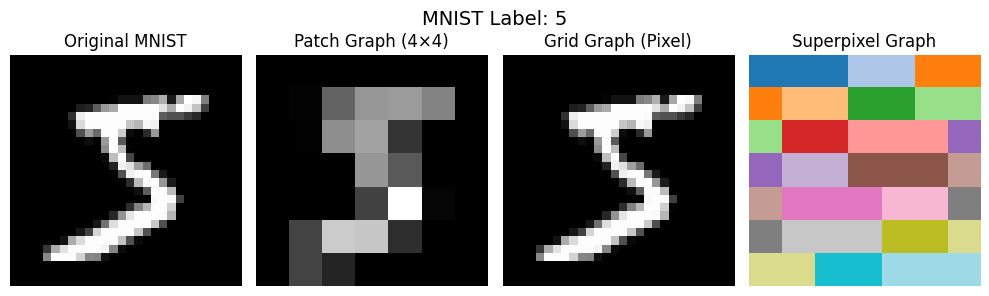

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import slic
from skimage import graph

# ===============================
# Load MNIST
# ===============================
ds = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=T.ToTensor()
)

img, label = ds[0]
img_np = img.squeeze().numpy()

# ===============================
# Patch Graph Visualization
# ===============================
def visualize_patch_graph(img, P=4):
    H, W = img.shape
    grid = np.zeros((H // P, W // P))

    for i in range(0, H, P):
        for j in range(0, W, P):
            grid[i // P, j // P] = img[i:i+P, j:j+P].mean()

    return grid

# ===============================
# Grid Graph Visualization
# ===============================
def visualize_grid_graph(img):
    return img  # pixel graph is visually identical

# ===============================
# Superpixel Graph Visualization
# ===============================
def visualize_superpixel_graph(img, n_segments=50):
    segments = slic(
        img,
        n_segments=n_segments,
        compactness=10,
        start_label=0,
        channel_axis=None
    )
    return segments

# ===============================
# Plot comparison
# ===============================
plt.figure(figsize=(10, 3))

# Original
plt.subplot(1, 4, 1)
plt.imshow(img_np, cmap="gray")
plt.title("Original MNIST")
plt.axis("off")

# Patch graph
plt.subplot(1, 4, 2)
plt.imshow(visualize_patch_graph(img_np, P=4), cmap="gray")
plt.title("Patch Graph (4×4)")
plt.axis("off")

# Grid graph
plt.subplot(1, 4, 3)
plt.imshow(visualize_grid_graph(img_np), cmap="gray")
plt.title("Grid Graph (Pixel)")
plt.axis("off")

# Superpixel graph
plt.subplot(1, 4, 4)
plt.imshow(visualize_superpixel_graph(img_np, 50), cmap="tab20")
plt.title("Superpixel Graph")
plt.axis("off")

plt.suptitle(f"MNIST Label: {label}", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_pyg_graph(data, pos, background=None, title=""):
    """
    data: PyG Data object
    pos:  (N, 2) numpy array of (x, y)
    background: image to show under graph
    """
    edge_index = data.edge_index.cpu().numpy()

    if background is not None:
        plt.imshow(background, cmap="gray")

    # edges
    for u, v in edge_index.T:
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        plt.plot([x1, x2], [y1, y2], "lime", alpha=0.4)

    # nodes
    plt.scatter(pos[:, 0], pos[:, 1],
                c=data.x.squeeze().cpu().numpy(),
                cmap="hot", s=30)

    plt.title(title)
    plt.axis("off")

In [ ]:
def patch_graph_with_pos(dataset, idx=0, P=4):
    img, label = dataset[idx]
    img = img.squeeze()

    nodes, pos = [], []
    for i in range(0, 28, P):
        for j in range(0, 28, P):
            patch = img[i:i+P, j:j+P]
            nodes.append(patch.mean())
            pos.append((j + P//2, i + P//2))

    x = torch.tensor(nodes).unsqueeze(1)

    edges = []
    W = 28 // P
    for i in range(len(nodes)):
        r, c = divmod(i, W)
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < W and 0 <= nc < W:
                edges.append([i, nr * W + nc])

    data = Data(
        x=x,
        edge_index=torch.tensor(edges).t(),
        y=torch.tensor(label)
    )

    return data, np.array(pos), img.numpy()

In [ ]:
def grid_graph_with_pos(dataset, idx=0, stride=3):
    img, label = dataset[idx]
    img = img.squeeze()

    pos, nodes, mapping = [], [], {}
    idx_new = 0

    for r in range(0, 28, stride):
        for c in range(0, 28, stride):
            mapping[(r, c)] = idx_new
            nodes.append(img[r, c])
            pos.append((c, r))
            idx_new += 1

    edges = []
    for (r, c), i in mapping.items():
        for dr, dc in [(stride,0),(0,stride)]:
            if (r+dr, c+dc) in mapping:
                j = mapping[(r+dr, c+dc)]
                edges += [[i, j], [j, i]]

    data = Data(
        x=torch.tensor(nodes).unsqueeze(1),
        edge_index=torch.tensor(edges).t(),
        y=torch.tensor(label)
    )

    return data, np.array(pos), img.numpy()

In [ ]:
from skimage.segmentation import slic
from skimage import graph

def superpixel_graph_with_pos(dataset, idx=0, n_segments=50):
    img, label = dataset[idx]
    img = img.squeeze().numpy()

    segments = slic(
        img,
        n_segments=n_segments,
        compactness=10,
        start_label=0,
        channel_axis=None
    )

    rag = graph.rag_mean_color(img, segments)

    x, pos = [], []
    for node in rag.nodes:
        mask = segments == node
        x.append(img[mask].mean())

        ys, xs = np.where(mask)
        pos.append((xs.mean(), ys.mean()))

    edges = []
    for u, v in rag.edges:
        edges += [[u, v], [v, u]]

    data = Data(
        x=torch.tensor(x).unsqueeze(1),
        edge_index=torch.tensor(edges).t(),
        y=torch.tensor(label)
    )

    return data, np.array(pos), img

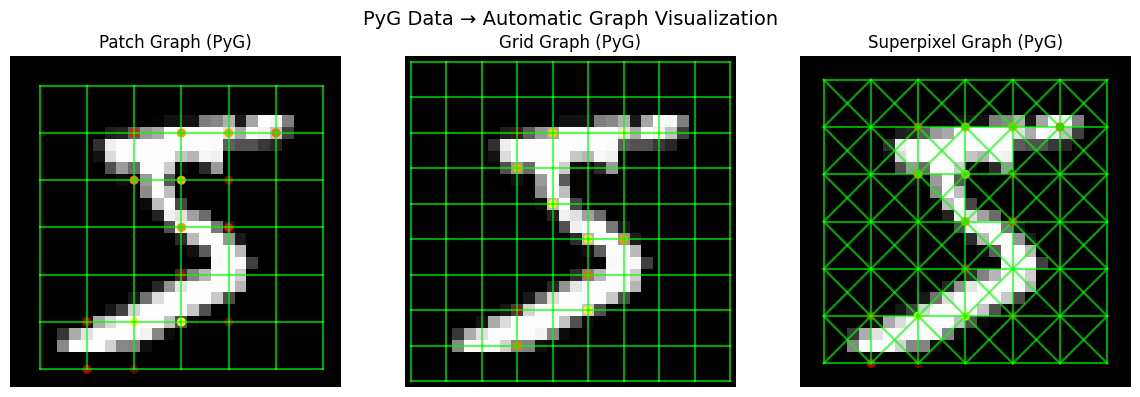

In [ ]:
import torchvision
import torchvision.transforms as T
from torch_geometric.data import Data # Add this import

ds = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=T.ToTensor()
)

plt.figure(figsize=(12,4))

data, pos, bg = patch_graph_with_pos(ds, idx=0, P=4)
plt.subplot(1,3,1)
plot_pyg_graph(data, pos, bg, "Patch Graph (PyG)")

data, pos, bg = grid_graph_with_pos(ds, idx=0, stride=3)
plt.subplot(1,3,2)
plot_pyg_graph(data, pos, bg, "Grid Graph (PyG)")

data, pos, bg = superpixel_graph_with_pos(ds, idx=0, n_segments=50)
plt.subplot(1,3,3)
plot_pyg_graph(data, pos, bg, "Superpixel Graph (PyG)")

plt.suptitle("PyG Data → Automatic Graph Visualization", fontsize=14)
plt.tight_layout()
plt.show()

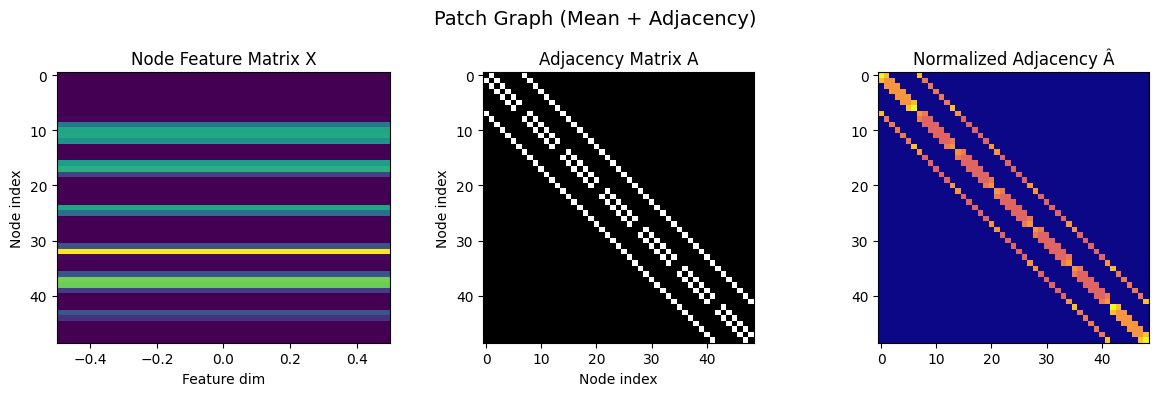

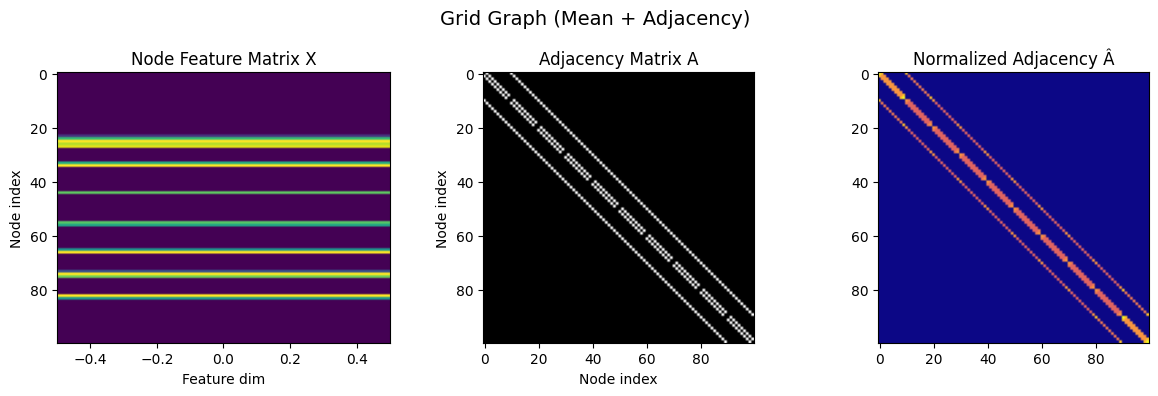

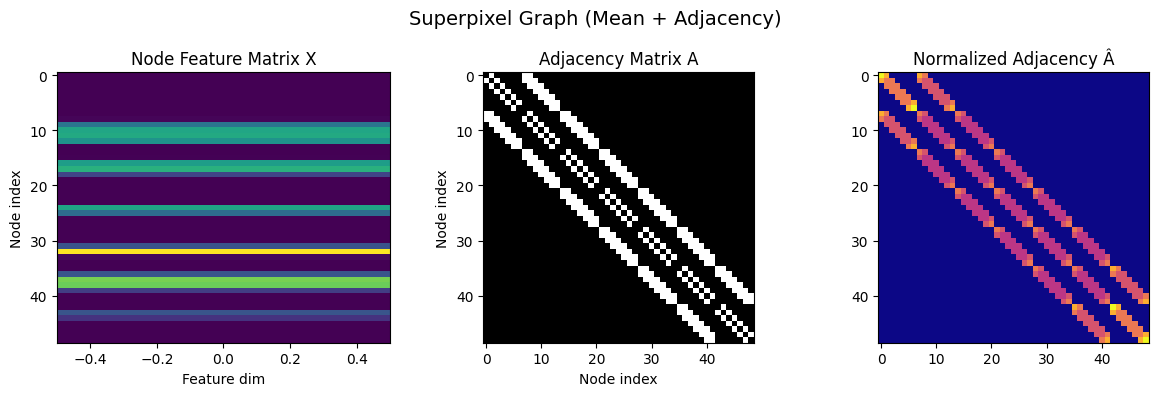

In [ ]:
import torch
import numpy as np

def pyg_to_matrices(data):
    N = data.num_nodes

    # Feature matrix X
    X = data.x.cpu().numpy()   # (N, 1)

    # Adjacency matrix A
    A = torch.zeros((N, N))
    src, dst = data.edge_index
    A[src, dst] = 1

    return X, A.numpy()

def normalize_adj(A):
    A_hat = A + np.eye(A.shape[0])
    D = np.diag(np.power(A_hat.sum(axis=1), -0.5))
    return D @ A_hat @ D

import matplotlib.pyplot as plt

def plot_graph_matrices(X, A, A_norm=None, title=""):
    fig, axs = plt.subplots(1, 3 if A_norm is not None else 2,
                            figsize=(12,4))

    # X (mean matrix)
    axs[0].imshow(X, aspect="auto", cmap="viridis")
    axs[0].set_title("Node Feature Matrix X")
    axs[0].set_xlabel("Feature dim")
    axs[0].set_ylabel("Node index")

    # A
    axs[1].imshow(A, cmap="gray")
    axs[1].set_title("Adjacency Matrix A")
    axs[1].set_xlabel("Node index")
    axs[1].set_ylabel("Node index")

    if A_norm is not None:
        axs[2].imshow(A_norm, cmap="plasma")
        axs[2].set_title("Normalized Adjacency Â")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

data, _, _ = patch_graph_with_pos(ds, idx=0, P=4)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)

plot_graph_matrices(X, A, A_norm, title="Patch Graph (Mean + Adjacency)")

data, _, _ = grid_graph_with_pos(ds, idx=0, stride=3)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)

plot_graph_matrices(X, A, A_norm, title="Grid Graph (Mean + Adjacency)")

data, _, _ = superpixel_graph_with_pos(ds, idx=0, n_segments=50)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)

plot_graph_matrices(X, A, A_norm, title="Superpixel Graph (Mean + Adjacency)")

In [3]:
def overlay_node_features(img, node_values, masks, title=""):
    """
    img: (H,W) original image
    node_values: (N,) node feature values
    masks: list of boolean masks, len = N
    """
    overlay = np.zeros_like(img, dtype=float)

    for v, m in zip(node_values, masks):
        overlay[m] = v

    plt.imshow(img, cmap="gray")
    plt.imshow(overlay, cmap="hot", alpha=0.6)
    plt.title(title)
    plt.axis("off")
    plt.colorbar(label="Node feature (mean)")
    plt.show()

def overlay_diffusion(img, A_norm, X, masks, title=""):
    diffused = A_norm @ X.squeeze()   # (N,)

    overlay = np.zeros_like(img, dtype=float)
    for v, m in zip(diffused, masks):
        overlay[m] = v

    plt.imshow(img, cmap="gray")
    plt.imshow(overlay, cmap="plasma", alpha=0.6)
    plt.title(title)
    plt.axis("off")
    plt.colorbar(label="ÂX diffusion")
    plt.show()

def patch_masks(P=4):
    masks = []
    for i in range(0, 28, P):
        for j in range(0, 28, P):
            m = np.zeros((28,28), dtype=bool)
            m[i:i+P, j:j+P] = True
            masks.append(m)
    return masks


def grid_masks(stride=3):
    masks = []
    for r in range(0, 28, stride):
        for c in range(0, 28, stride):
            m = np.zeros((28,28), dtype=bool)
            m[r, c] = True
            masks.append(m)
    return masks

from skimage.segmentation import slic

def superpixel_masks(img, n_segments=50):
    segments = slic(
        img,
        n_segments=n_segments,
        compactness=10,
        start_label=0,
        channel_axis=None
    )
    masks = [(segments == i) for i in np.unique(segments)]
    return masks

img, _ = ds[0]
img = img.squeeze().numpy()
data, _, _ = patch_graph_with_pos(ds, idx=0, P=4)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)

masks = patch_masks(P=4)

overlay_node_features(img, X.squeeze(), masks,
                      title="Patch Graph: Node Mean (X)")

overlay_diffusion(img, A_norm, X, masks,
                  title="Patch Graph: Diffusion (ÂX)")

data, _, _ = grid_graph_with_pos(ds, idx=0, stride=3)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)

masks = grid_masks(stride=3)

overlay_node_features(img, X.squeeze(), masks,
                      title="Grid Graph: Node Mean (X)")

overlay_diffusion(img, A_norm, X, masks,
                  title="Grid Graph: Diffusion (ÂX)")

data, _, _ = superpixel_graph_with_pos(ds, idx=0, n_segments=50)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)

masks = superpixel_masks(img, n_segments=50)

overlay_node_features(img, X.squeeze(), masks,
                      title="Superpixel Graph: Node Mean (X)")

overlay_diffusion(img, A_norm, X, masks,
                  title="Superpixel Graph: Diffusion (ÂX)")

NameError: name 'ds' is not defined

In [5]:
import torch
from torch_geometric.data import Data

def patch_graph_with_pos(ds, idx=0, P=4):
    img, label = ds[idx]
    img = img.squeeze()  # (28,28)

    H, W = img.shape
    nodes = []
    pos = []

    for i in range(0, H, P):
        for j in range(0, W, P):
            patch = img[i:i+P, j:j+P]
            nodes.append(patch.mean())
            pos.append([i + P/2, j + P/2])

    x = torch.tensor(nodes, dtype=torch.float).unsqueeze(1)
    pos = torch.tensor(pos, dtype=torch.float)

    N = len(nodes)
    edge_index = []

    grid_w = W // P
    for idx in range(N):
        r, c = divmod(idx, grid_w)
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < grid_w and 0 <= nc < grid_w:
                edge_index.append([idx, nr * grid_w + nc])

    edge_index = torch.tensor(edge_index).t().contiguous()
    return Data(x=x, edge_index=edge_index, pos=pos), img, label


def grid_graph_with_pos(ds, idx=0, stride=3):
    img, label = ds[idx]
    img = img.squeeze()

    nodes = []
    pos = []

    for r in range(0, 28, stride):
        for c in range(0, 28, stride):
            nodes.append(img[r, c])
            pos.append([r, c])

    x = torch.tensor(nodes, dtype=torch.float).unsqueeze(1)
    pos = torch.tensor(pos, dtype=torch.float)

    N = len(nodes)
    edge_index = []

    w = 28 // stride
    for i in range(N):
        r, c = divmod(i, w)
        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < w and 0 <= nc < w:
                edge_index.append([i, nr * w + nc])

    edge_index = torch.tensor(edge_index).t().contiguous()
    return Data(x=x, edge_index=edge_index, pos=pos), img, label


from skimage.segmentation import slic
import numpy as np

def superpixel_graph_with_pos(ds, idx=0, n_segments=50):
    img, label = ds[idx]
    img = img.squeeze().numpy()

    segments = slic(
        img,
        n_segments=n_segments,
        compactness=10,
        start_label=0,
        channel_axis=None
    )

    nodes = []
    pos = []
    masks = []

    for i in np.unique(segments):
        mask = segments == i
        nodes.append(img[mask].mean())
        coords = np.argwhere(mask)
        pos.append(coords.mean(axis=0))
        masks.append(mask)

    x = torch.tensor(nodes, dtype=torch.float).unsqueeze(1)
    pos = torch.tensor(pos, dtype=torch.float)

    edge_index = []
    H, W = segments.shape

    for r in range(H - 1):
        for c in range(W - 1):
            a = segments[r, c]
            b = segments[r + 1, c]
            d = segments[r, c + 1]
            if a != b:
                edge_index.append([a, b])
            if a != d:
                edge_index.append([a, d])

    edge_index = torch.tensor(edge_index).t().contiguous()
    return Data(x=x, edge_index=edge_index, pos=pos), img, label

In [7]:
import torchvision
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor()
])

ds = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.54MB/s]


In [9]:
import numpy as np

def pyg_to_matrices(data):
    """
    Convert a PyG Data object to (X, A) numpy matrices.

    data.x          : (N, F)
    data.edge_index : (2, E)

    Returns
    -------
    X : (N, F) numpy array
    A : (N, N) adjacency matrix (unweighted)
    """
    X = data.x.detach().cpu().numpy()

    N = X.shape[0]
    A = np.zeros((N, N), dtype=np.float32)

    edge_index = data.edge_index.detach().cpu().numpy()
    A[edge_index[0], edge_index[1]] = 1.0

    return X, A

In [11]:
def normalize_adj(A):
    """
    Symmetric normalization: D^{-1/2} (A + I) D^{-1/2}
    """
    A = A + np.eye(A.shape[0])
    D = np.diag(1.0 / np.sqrt(A.sum(axis=1)))
    return D @ A @ D

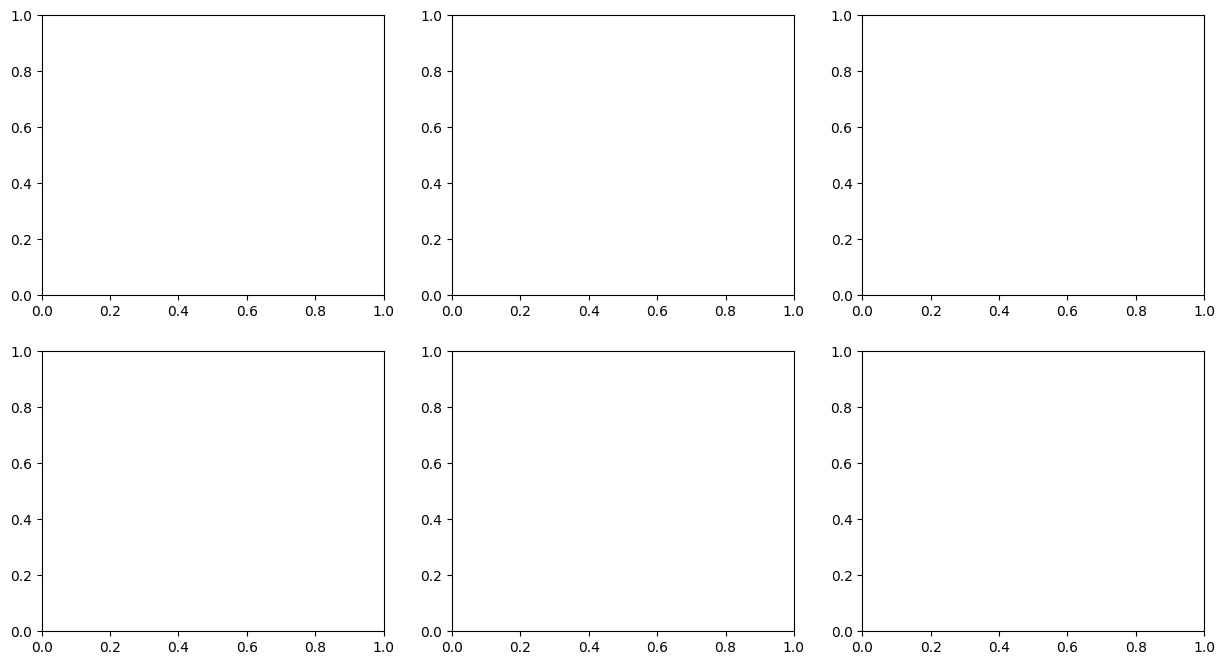

In [16]:
# Get one sample image from the dataset
img, label = ds[0]

# Convert to (28, 28) numpy array
img = img.squeeze().numpy()
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(15, 8))


In [17]:
def overlay_node_features(img, node_values, masks, ax, title=""):
    overlay = np.zeros_like(img, dtype=float)

    for v, m in zip(node_values, masks):
        overlay[m] = v

    im1 = ax.imshow(img, cmap="gray")
    im2 = ax.imshow(overlay, cmap="hot", alpha=0.6)
    ax.set_title(title)
    ax.axis("off")
    return im2


def overlay_diffusion(img, A_norm, X, masks, ax, title=""):
    diffused = A_norm @ X.squeeze()

    overlay = np.zeros_like(img, dtype=float)
    for v, m in zip(diffused, masks):
        overlay[m] = v

    im1 = ax.imshow(img, cmap="gray")
    im2 = ax.imshow(overlay, cmap="plasma", alpha=0.6)
    ax.set_title(title)
    ax.axis("off")
    return im2

data, _, _ = patch_graph_with_pos(ds, idx=0, P=4)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)
masks = patch_masks(P=4)

im = overlay_node_features(
    img, X.squeeze(), masks,
    ax=axes[0, 0],
    title="Patch Graph: Node Mean (X)"
)

overlay_diffusion(
    img, A_norm, X, masks,
    ax=axes[1, 0],
    title="Patch Graph: Diffusion (ÂX)"
)

data, _, _ = grid_graph_with_pos(ds, idx=0, stride=3)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)
masks = grid_masks(stride=3)

overlay_node_features(
    img, X.squeeze(), masks,
    ax=axes[0, 1],
    title="Grid Graph: Node Mean (X)"
)

overlay_diffusion(
    img, A_norm, X, masks,
    ax=axes[1, 1],
    title="Grid Graph: Diffusion (ÂX)"
)

data, _, _ = superpixel_graph_with_pos(ds, idx=0, n_segments=50)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)
masks = superpixel_masks(img, n_segments=50)

overlay_node_features(
    img, X.squeeze(), masks,
    ax=axes[0, 2],
    title="Superpixel Graph: Node Mean (X)"
)

overlay_diffusion(
    img, A_norm, X, masks,
    ax=axes[1, 2],
    title="Superpixel Graph: Diffusion (ÂX)"
)

/tmp/ipython-input-2378499114.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  pos = torch.tensor(pos, dtype=torch.float)


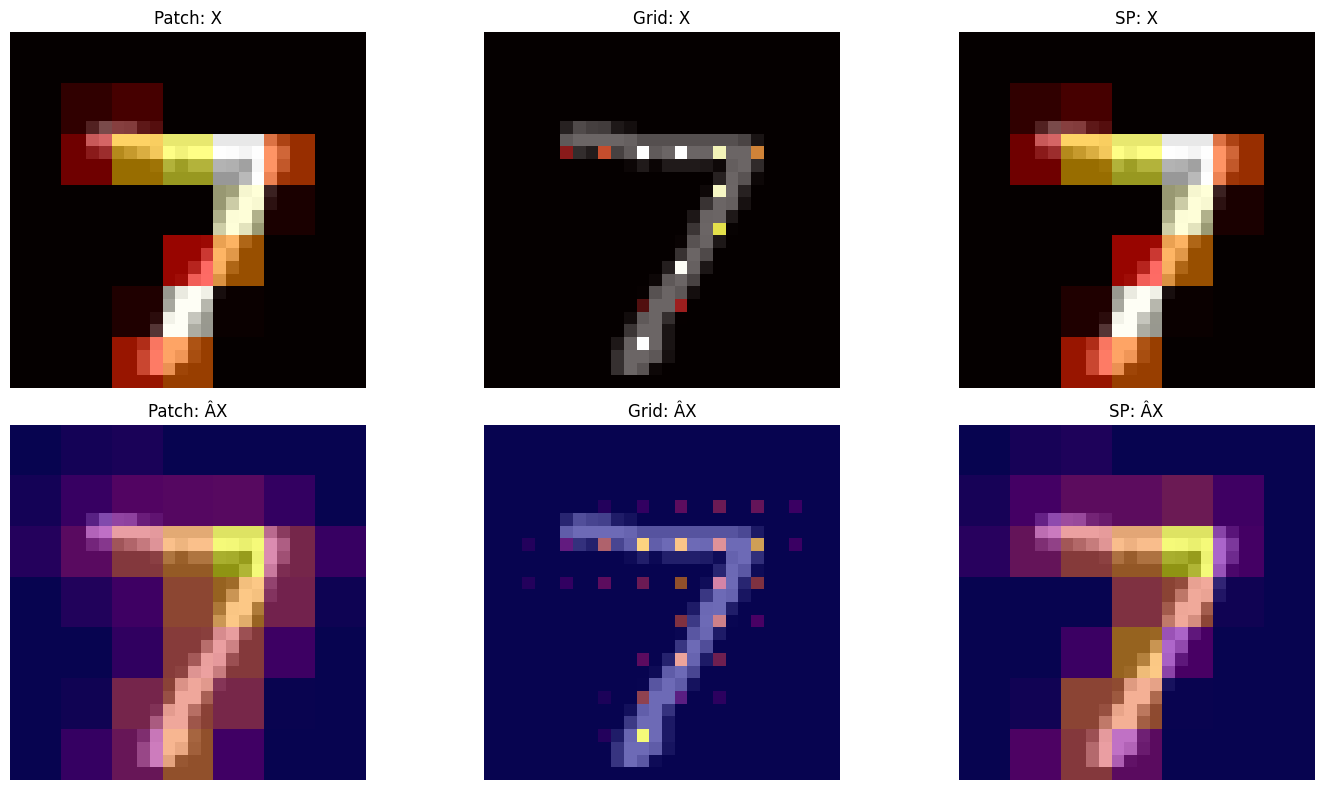

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

data, _, _ = patch_graph_with_pos(ds, idx=0, P=4)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)
masks = patch_masks(P=4)

overlay_node_features(img, X.squeeze(), masks, axes[0, 0], "Patch: X")
overlay_diffusion(img, A_norm, X, masks, axes[1, 0], "Patch: ÂX")

data, _, _ = grid_graph_with_pos(ds, idx=0, stride=3)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)
masks = grid_masks(stride=3)

overlay_node_features(img, X.squeeze(), masks, axes[0, 1], "Grid: X")
overlay_diffusion(img, A_norm, X, masks, axes[1, 1], "Grid: ÂX")

data, _, _ = superpixel_graph_with_pos(ds, idx=0, n_segments=50)
X, A = pyg_to_matrices(data)
A_norm = normalize_adj(A)
masks = superpixel_masks(img, n_segments=50)

overlay_node_features(img, X.squeeze(), masks, axes[0, 2], "SP: X")
overlay_diffusion(img, A_norm, X, masks, axes[1, 2], "SP: ÂX")

plt.tight_layout()
plt.show()

In [20]:
!pip install qrcode[pil]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00


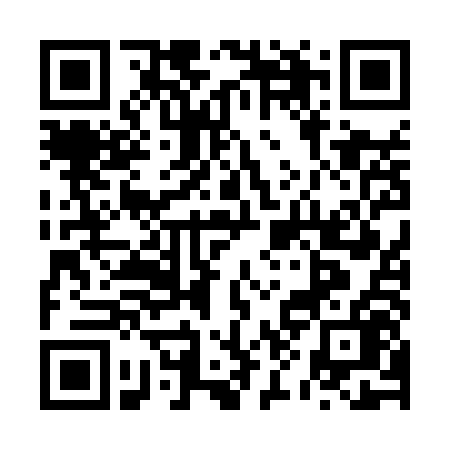

In [21]:
import qrcode

# The data you want to encode
data = "https://colab.research.google.com/drive/1yfHWJtOTnR9cHtcWdR299TLFLobOH90a?usp=sharing"

# Create a QRCode object
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)

qr.add_data(data)
qr.make(fit=True)

# Create the image
img = qr.make_image(fill_color="black", back_color="white")

# Save to file
img.save("qrcode.png")

# Show the image in Colab
from IPython.display import Image
Image("qrcode.png")